In [1]:
using Flux,LinearAlgebra,IterTools,Plots,LaTeXStrings

In [3]:
function Df(model, x)
    # x: single datapoint
    m = length(model(x))
    k = sum(length, Flux.params(model)) # Total amount of params

    # Þetta anonymous function reiknar gradient fyrir hvert function í outputinu frá 1:m
    jac = (fi) -> Flux.jacobian(() -> model(x)[fi],Flux.params(model)) # anonymous function

    # Skilgreini tómt Jacobian fylki
    Jacob = zeros(k,m)

    for func_i = 1:m
        current_col = []
        for param_i = 1:length(Flux.params(model))
            push!(current_col, jac(func_i)[Flux.params(model)[param_i]]) # Fyrir hvern parametra W1, B1, W2...
        end
        current_col = collect(Iterators.flatten(current_col)) # Flatten, flet allt
        # --- Spurning hvort hægt sé að gera þetta skilvirkara?
        # --- Held samt að Iterators pakkinn eigi að vera nokkuð skilvirkur

        Jacob[:, func_i] .= current_col # geri current_col að næsta dálka vigri jacobian
    end

    return Jacob # Þetta er Df fylkið í bilblíunni
end

function kernel(model, x)
    # x: dataset
    N = length(x)
    m = length(model(x[1]))  # Number of functions in the model output
    K = zeros(N*m, N*m)

    for i = 1:N
        for j = 1:N
            block = Df(model, x[i])' * Df(model, x[j])
            K[(i-1)*m+1:i*m, (j-1)*m+1:j*m] .= block
        end
    end

    return K
end

kernel (generic function with 1 method)

In [62]:
# nodes on hidden layer
Nh_list = [10 1_000_000_000]
models = []
activation = sigmoid

InputDim = 2

for Nh in 1:length(Nh_list)
    push!(models,Chain(Dense(InputDim=>Nh_list[Nh],activation),Dense(Nh_list[Nh]=>InputDim))|>f64)
end

x1 = [2;2]
x2 = [2;4]
x3 = [2;4.2]
x4 = [1.92;7]
x5 = [18.02;300]
x6 = [-3;17]
x7 = [312;-0.02]
x = [x1,x2,x3,x4,x5,x6,x7]
Kernels = []
for model in models
    push!(Kernels, kernel(model, x))
end

Kernels_Norms = []

for (i, K) in enumerate(Kernels)
    Nh = Nh_list[i] # Get the corresponding Nh for this kernel
    normalized_K = K / sqrt(Nh) # Normalize the kernel matrix
    push!(Kernels_Norms, normalized_K) # Store the normalized kernel
end

λ_values = Float64.([])
for K in Kernels_Norms
    push!(λ_values, eigen(K).values) # Compute eigenvalues for each kernel and store
end


λ_values
display(Kernels_Norms[1])
display(Kernels_Norms[2])

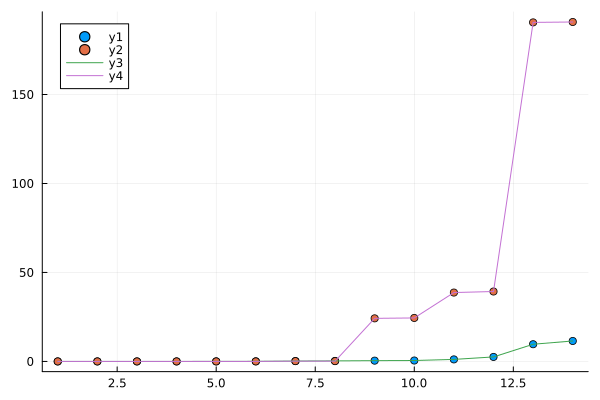

In [61]:
# Start with the first scatter plot
scatter(λ_values)
plot!(λ_values)


1×50 adjoint(::Vector{Float64}) with eltype Float64:
 -1.10151  -0.279287  -0.889878  0.833003  …  0.524056  0.976233  0.134756